In [1]:
# Import libraries:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
# header = {'User-Agent':'cjbratkovics2'}

In [2]:
# base_url = 'https://www.trulia.com/'
# url = 'https://www.trulia.com/NY/New_York/10011/'

In [3]:
# base_res = requests.get(base_url, headers = header)
# res = requests.get(url, headers = header)

In [4]:
def gather_housing_data(url):
    # Initialize results list to store all data from this page.
    results = []
    
    # Initialize header, request, and beautifulsoup.
    header = {'User-Agent':'cjbratkovics2'}
    res = requests.get(url, headers = header)
    soup = BeautifulSoup(res.content, 'lxml')
    
    # Find and store the price of each house; most important.
    house_prices = soup.find_all('span', {'class': 'cardPrice h5 man pan typeEmphasize noWrap typeTruncate'})
    prices = []
    for i in house_prices:
        prices.append(i.text)

    # Find and store each house's address.
    house_addresses = soup.find_all('div', {'class': 'h6 typeWeightNormal typeTruncate typeLowlight mvn'})
    addresses = []
    for i in house_addresses:
        addresses.append(i.text)

    # Find and store the city/state of each house.
    house_cities = soup.find_all('div', {'class': 'typeTruncate typeLowlight'})
    cities = []
    for i in house_cities:
        cities.append(i.text)
    
    # Find and store the bedrooms, bathrooms, and area of each house.
    general_house_info = soup.find_all('ul', {'data-testid': 'cardDescription'})
    info = []
    for g in general_house_info:
        s = g.text
        s = s.replace(',', '')
        info.append(s)

    # Save all data for each house in the result dictionary.
    for i in range(len(house_prices)):
        # Initialize empty result dictionary to store results from each page.
        result = {}
        
        # Store all meaningful values to result dictionary.
        result['price'] = prices[i]
        result['qualities'] = info[i]
        result['address'] = addresses[i]
        result['city/state'] = cities[i]
    
        # Add all result dictionary data to results list.
        results.append(result)
    
    # Return the results from the page and url.
    return results, url

In [5]:
def update_url(page_url, count):
    
    # Assume there is no next page.
    next_exists = False
    
    # Initialize header, request, and beautifulsoup.
    header = {'User-Agent':'cjbratkovics2'}
    res = requests.get(page_url, headers = header)
    soup = BeautifulSoup(res.content, 'lxml')

    # Find and store the next page url.
    next_pages = (soup.find_all('a', {'class': 'pvl phm'}))
    
    for p in next_pages:
        if (p.attrs['aria-label'] == 'Next page'):
            next_page_url = p.attrs['href']
            next_exists = True
        else:
            next_page_url = page_url
    # If the next page doesn't exist, assign next_url to None.
    if next_exists == False:
        count += 1
            
    # Return the results from this page and the next page's url.
    return next_page_url, count

In [6]:
def data_cleaning(df):
    df['studio'] = df['qualities'].str.extract(r'(Studio)')
    
    df['bath'] = df['qualities'].str.extract(r'([0123456789]ba)')
    df['bath'] = df['bath'].map(lambda bath_cell: np.nan if bath_cell == 'NaN' else str(bath_cell))
    df['bath'] = df['bath'].map(lambda bath_cell: bath_cell.replace('ba', ''))
    df['bath'] = df['bath'].map(lambda bath_cell: bath_cell.replace('0', '10'))
    df['bath'] = df['bath'].astype(float)
    
    df['bed'] = df['qualities'].str.extract(r'([0123456789]bd)')
    df['bed'] = df['bed'].map(lambda bed_cell: np.nan if bed_cell == 'NaN' else str(bed_cell))
    df['bed'] = df['bed'].map(lambda bath_cell: bath_cell.replace('bd', ''))
    df['bed'] = df['bed'].astype(float)
    
    df['price'] = df['price'].map(lambda price_cell: price_cell.replace('$', ''))
    df['price'] = df['price'].map(lambda price_cell: price_cell.replace(',', ''))
    df['price'] = df['price'].astype(float)
    
    df['drop_sqft'], df['sqft_test'] = df['qualities'].str.split('[0123456789]ba', 1).str
    df['sqft_test'] = df['sqft_test'].map(lambda sqft_cell: np.nan if sqft_cell == '' else str(sqft_cell))
    df['sqft'], df['sqft_test_2'] = df['sqft_test'].str.split(' ', 1).str
    df['sqft'] = df['sqft'].astype(float)
    
    
    df.loc[df['studio'] == 'Studio', 'bed'] = 1
    df.loc[df['studio'] == 'Studio', 'bath'] = 1
    df.loc[df['studio'] != 'Studio', 'studio'] = 0
    df.loc[df['studio'] == 'Studio', 'studio'] = 1
    df['studio'] = df['studio'].astype(float)
    
    df.drop(columns= ['drop_sqft', 'sqft_test', 'sqft_test_2', 'qualities'], inplace=True)
    
    return df

In [7]:
def driver(zipcode):
    
    # Search for zipcode input on Trulia.com home page.
    # Get the url from that search as first_url.
    
    # Initialize url based on zipcode.
    first_url = ('https://www.trulia.com/NY/New_York/' + str(zipcode) + '/')
    
    # Initialize header, request, and beautifulsoup.
    header = {'User-Agent':'cjbratkovics2'}
    res = requests.get(first_url, headers = header)
    soup = BeautifulSoup(res.content, 'lxml')
    
    count = 0
    all_results = []
    
    # Find and store the last page url.
    next_pages = (soup.find_all('a', {'class': 'pvl phm'}))
    
    link_list = []
    link_with_nums = {}
    num_link = {}
    
    for p in next_pages:
        num_link['text'] = p.text
        num_link['attributes'] = p.attrs['href']
        link_list.append(p.attrs['href'])
        
    link_with_nums['page_link'] = np.unique(link_list)
    last_page_url = link_with_nums['page_link'][0]
    
    results, page_url = gather_housing_data(first_url)
    all_results.append(results)
    
    while count < 2:
        if count != 1:
            next_page_url, count = update_url(page_url, count)
            results, page_url = gather_housing_data(next_page_url)
            all_results.append(results)
        else:
            results, page_url = gather_housing_data(last_page_url)
            all_results.append(results)
            count += 1
            
    return all_results

In [8]:
all_results = driver(10011)

In [9]:
def df_builder(all_results):
    r = []
    for i in all_results:
        for j in i:
            r.append(j)
            
    df = pd.DataFrame(r)
    
    df.drop_duplicates(subset = 'address', inplace=True)
    
    return df

In [10]:
big_df = df_builder(all_results)

In [11]:
big_df = data_cleaning(big_df)

In [12]:
big_df.dtypes

address        object
city/state     object
price         float64
studio        float64
bath          float64
bed           float64
sqft          float64
dtype: object

In [13]:
big_df.shape

(430, 7)

In [14]:
big_df.head(40)

,address,city/state,price,studio,bath,bed,sqft
0,360 W 20th St #3-F,"Chelsea, New York, NY",695000.0,0.0,1.0,1.0,NaN
1,429 W 24th St #4F,"Chelsea, New York, NY",599000.0,0.0,1.0,1.0,700.0
2,32 W 18th St,"Flatiron District, New York, NY",14950000.0,0.0,6.0,4.0,6733.0
3,451 W 24th St,"Chelsea, New York, NY",13950000.0,0.0,5.0,4.0,5000.0
4,155 W 20th St #4B,"Chelsea, New York, NY",825000.0,0.0,1.0,1.0,800.0
5,234 W 20th St #1B,"Chelsea, New York, NY",2995000.0,0.0,3.0,3.0,2223.0
6,101 W 12th St #19E,"Greenwich Village, New York, NY",950000.0,0.0,1.0,1.0,364679.0
7,470 W 24th St #17B,"Chelsea, New York, NY",3500000.0,0.0,2.0,2.0,1385.0
8,305 W 18th St #5F,"Chelsea, New York, NY",939000.0,0.0,1.0,1.0,NaN
9,165 W 20th St #3L,"Chelsea, New York, NY",1049000.0,0.0,1.0,1.0,850.0


In [15]:
big_df.isnull().sum()

address        0
city/state     0
price          0
studio         0
bath           1
bed            3
sqft          60
dtype: int64

In [16]:
big_df['address'].value_counts()

201 W 21st St #4B        1
130 W 19th St #6B        1
151 W 17th St #2H        1
100 W 12th St #4K        1
224 W 18th St #5B        1
37 W 12th St #7G         1
505 W 19th St #7A        1
200 W 20th St #409       1
360 W 22nd St #8B        1
40 5th Ave #10D          1
2 5th Ave #8Q            1
2 5th Ave #4-O           1
221 W 21st St #2D        1
450 W 17th St #1222      1
76 11th Ave #15E         1
208 W 15th St            1
360 W 21st St #3A        1
166 W 18th St #5C        1
342 W 21st St #4A        1
452 W 19th St #1D        1
145 W 13th St #103       1
405 W 23rd St #12J       1
505 W 19th St #6W        1
315 W 23rd St #8F        1
231 W 16th St #1WF       1
125 W 21st St #4B        1
261 W 22nd St #22        1
503 W 24th St #7         1
124 W 23rd St #9A        1
555 W 23rd St #S5F       1
                        ..
2 5th Ave #2S            1
175 W 13th St #17E       1
320 W 19th St #1B        1
450 W 17th St #1122      1
250 W 24th St #3GW       1
117 W 21st St #TH        1
4

In [17]:
big_df[big_df['address'] == '442 W 22nd St #1']

,address,city/state,price,studio,bath,bed,sqft
33,442 W 22nd St #1,"Chelsea, New York, NY",9995000.0,0.0,7.0,5.0,NaN


In [18]:
big_df.shape

(430, 7)

In [19]:
# big_df.to_csv('./trulia_10011_final_df.csv')

In [20]:
def summary_stats(df):
    all_stats = []
    numeric_cols = list(df.select_dtypes(include=['float64']).columns)
    for col in numeric_cols:
        stat_col = df[col]
        stats = {}
        
        stat_name = col
        stats['name'] = col
        
        stat_sum = np.sum(stat_col)
        stats['sum'] = stat_sum
        
        stat_mean = np.mean(stat_col)
        stats['mean'] = stat_mean
        
        stat_min = np.min(stat_col)
        stats['min'] = stat_min
        
        stat_max = np.max(stat_col)
        stats['max'] = stat_max
        
#         if col == 'price':
#             stat_med = np.median(stat_col)
#             stats['median'] = stat_med
        
        all_stats.append(stats)
        
    return all_stats

In [21]:
stats = summary_stats(big_df)
stats

[{'name': 'price',
  'sum': 1817464882.0,
  'mean': 4226662.51627907,
  'min': 425000.0,
  'max': 52500000.0},
 {'name': 'studio',
  'sum': 52.0,
  'mean': 0.12093023255813953,
  'min': 0.0,
  'max': 1.0},
 {'name': 'bath',
  'sum': 1008.0,
  'mean': 2.3496503496503496,
  'min': 1.0,
  'max': 10.0},
 {'name': 'bed',
  'sum': 909.0,
  'mean': 2.128805620608899,
  'min': 1.0,
  'max': 9.0},
 {'name': 'sqft',
  'sum': 8452007.0,
  'mean': 22843.262162162162,
  'min': 371.0,
  'max': 403741.0}]

In [22]:
test = pd.DataFrame.from_dict(stats)

In [23]:
test

,max,mean,min,name,sum
0,52500000.0,4.226663e+06,425000.0,price,1.817465e+09
1,1.0,1.209302e-01,0.0,studio,5.200000e+01
2,10.0,2.349650e+00,1.0,bath,1.008000e+03
3,9.0,2.128806e+00,1.0,bed,9.090000e+02
4,403741.0,2.284326e+04,371.0,sqft,8.452007e+06


# Try and see if median can be fixed

In [24]:
def summary_stats(df):
    all_stats = []
    numeric_cols = list(df.select_dtypes(include=['float64']).columns)
    for col in numeric_cols:
        stat_col = df[col]
        stats = {}
        
        stat_name = col
        stats['name'] = col
        
        stat_sum = np.sum(stat_col)
        stats['sum'] = stat_sum
        
        stat_mean = np.mean(stat_col)
        stats['mean'] = stat_mean
        
        stat_median = np.nanmedian(stat_col)
        stats['median'] = stat_median
        
        stat_min = np.min(stat_col)
        stats['min'] = stat_min
        
        stat_max = np.max(stat_col)
        stats['max'] = stat_max
        
#         if col == 'price':
#             stat_med = np.median(stat_col)
#             stats['median'] = stat_med
        
        all_stats.append(stats)
        
    return all_stats

In [25]:
stats = summary_stats(big_df)
stats

[{'name': 'price',
  'sum': 1817464882.0,
  'mean': 4226662.51627907,
  'median': 2150000.0,
  'min': 425000.0,
  'max': 52500000.0},
 {'name': 'studio',
  'sum': 52.0,
  'mean': 0.12093023255813953,
  'median': 0.0,
  'min': 0.0,
  'max': 1.0},
 {'name': 'bath',
  'sum': 1008.0,
  'mean': 2.3496503496503496,
  'median': 2.0,
  'min': 1.0,
  'max': 10.0},
 {'name': 'bed',
  'sum': 909.0,
  'mean': 2.128805620608899,
  'median': 2.0,
  'min': 1.0,
  'max': 9.0},
 {'name': 'sqft',
  'sum': 8452007.0,
  'mean': 22843.262162162162,
  'median': 1631.5,
  'min': 371.0,
  'max': 403741.0}]

In [26]:
test = pd.DataFrame.from_dict(stats)

In [27]:
test

,max,mean,median,min,name,sum
0,52500000.0,4.226663e+06,2150000.0,425000.0,price,1.817465e+09
1,1.0,1.209302e-01,0.0,0.0,studio,5.200000e+01
2,10.0,2.349650e+00,2.0,1.0,bath,1.008000e+03
3,9.0,2.128806e+00,2.0,1.0,bed,9.090000e+02
4,403741.0,2.284326e+04,1631.5,371.0,sqft,8.452007e+06


In [28]:
test = test[['name', 'mean', 'median', 'max', 'min', 'sum']]

In [29]:
test

,name,mean,median,max,min,sum
0,price,4.226663e+06,2150000.0,52500000.0,425000.0,1.817465e+09
1,studio,1.209302e-01,0.0,1.0,0.0,5.200000e+01
2,bath,2.349650e+00,2.0,10.0,1.0,1.008000e+03
3,bed,2.128806e+00,2.0,9.0,1.0,9.090000e+02
4,sqft,2.284326e+04,1631.5,403741.0,371.0,8.452007e+06


In [30]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [31]:
test

,name,mean,median,max,min,sum
0,price,4226662.52,2150000.00,52500000.00,425000.00,1817464882.00
1,studio,0.12,0.00,1.00,0.00,52.00
2,bath,2.35,2.00,10.00,1.00,1008.00
3,bed,2.13,2.00,9.00,1.00,909.00
4,sqft,22843.26,1631.50,403741.00,371.00,8452007.00


# Making visuals

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
big_df.head()

,address,city/state,price,studio,bath,bed,sqft
0,360 W 20th St #3-F,"Chelsea, New York, NY",695000.00,0.00,1.00,1.00,nan
1,429 W 24th St #4F,"Chelsea, New York, NY",599000.00,0.00,1.00,1.00,700.00
2,32 W 18th St,"Flatiron District, New York, NY",14950000.00,0.00,6.00,4.00,6733.00
3,451 W 24th St,"Chelsea, New York, NY",13950000.00,0.00,5.00,4.00,5000.00
4,155 W 20th St #4B,"Chelsea, New York, NY",825000.00,0.00,1.00,1.00,800.00


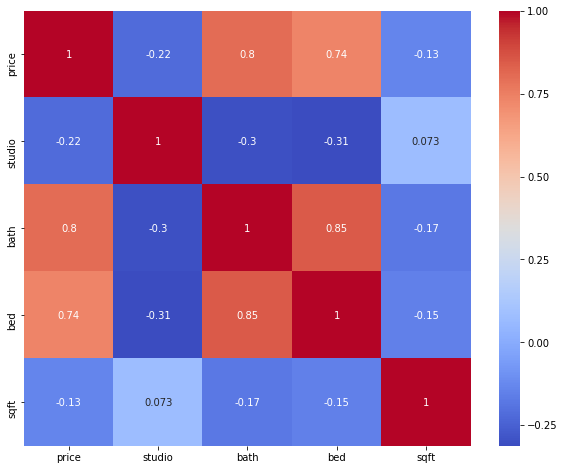

In [38]:
plt.figure(figsize= (10, 8))
sns.heatmap(big_df.corr(), annot = True, cmap = 'coolwarm');

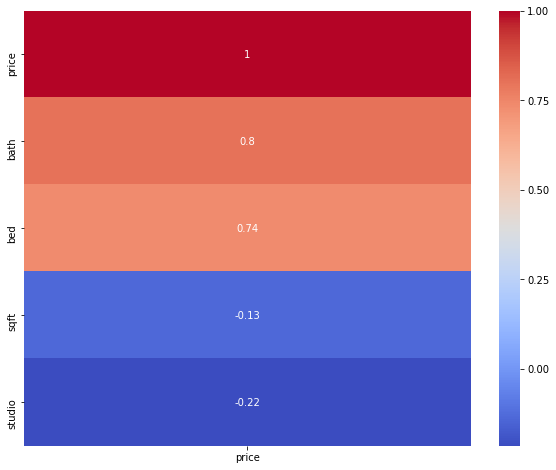

In [42]:
plt.figure(figsize= (10, 8))
sns.heatmap(big_df.corr()[['price']].sort_values('price', ascending = False), annot = True, cmap = 'coolwarm');

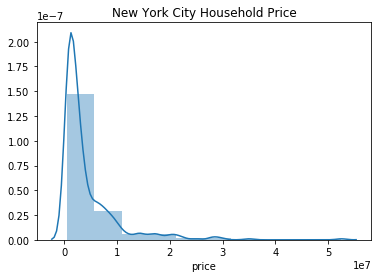

In [44]:
sns.distplot(big_df['price'], bins = 10, 
             kde = True).set_title('New York City Household Price');